### Import data 

In [28]:
import pandas as pd
df = pd.read_csv('/Users/baselhussein/Projects/ilearn/lda-analysis/data/p01_history_clean.csv')
df.head()

,order,id,date,time,title,url,visitCount,typedCount,transition,text
0,0,64,2/2/22,15:35:02,Philosophy of Artificial Intelligence - Biblio...,https://philpapers.org/browse/philosophy-of-ar...,1,0,link,\n\nSign in | Create an account\nPhilPapers Ph...
1,1,63,2/2/22,15:34:32,Philosophy of artificial intelligence - Google...,https://www.google.com/search?q=Philosophy+of+...,2,0,link,\n\nSkip to main contentAccessibility help\nAc...
2,2,63,2/2/22,15:34:31,Philosophy of artificial intelligence - Google...,https://www.google.com/search?q=Philosophy+of+...,2,0,link,\n\nSkip to main contentAccessibility help\nAc...
3,3,62,2/2/22,15:33:54,Rule engines - Google Search,https://www.google.com/search?q=Rule+engines,2,0,link,\n\nSkip to main contentAccessibility help\nAc...
4,4,62,2/2/22,15:33:53,Rule engines - Google Search,https://www.google.com/search?q=Rule+engines,2,0,link,\n\nSkip to main contentAccessibility help\nAc...


### Preprocessing

In [29]:
### clean df for text and time

df_text = df[['text', 'title']]

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
import gensim
import pandas as pd
import re
import math

def clean_text(df=df_text, 
                 text='text', 
                ):
    
    df_copy = df.copy()
    
    
    # lowercase the text
    df_copy['preprocessed_' + text] = df_copy[text].str.lower()
    
    # filter out stop words 
    en_stop_words = set(stopwords.words('english'))
    extended_stop_words = en_stop_words | \
                        {
                            'Sign in', 'com', 'www'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + text] = df_copy['preprocessed_' + text].apply(lambda row: ' '.join([word for word in row.split() if (not word in extended_stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the text
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + text] = df_copy['preprocessed_' + text].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy
  
df_text_clean = clean_text(df_text)
df_text_clean.head()

,text,title,preprocessed_text,tokenized_text
0,\n\nSign in | Create an account\nPhilPapers Ph...,Philosophy of Artificial Intelligence - Biblio...,sign | create account philpapers philpeople ph...,"[sign, create, account, philpapers, philpeople..."
1,\n\nSkip to main contentAccessibility help\nAc...,Philosophy of artificial intelligence - Google...,skip main contentaccessibility help accessibil...,"[skip, main, contentaccessibility, help, acces..."
2,\n\nSkip to main contentAccessibility help\nAc...,Philosophy of artificial intelligence - Google...,skip main contentaccessibility help accessibil...,"[skip, main, contentaccessibility, help, acces..."
3,\n\nSkip to main contentAccessibility help\nAc...,Rule engines - Google Search,skip main contentaccessibility help accessibil...,"[skip, main, contentaccessibility, help, acces..."
4,\n\nSkip to main contentAccessibility help\nAc...,Rule engines - Google Search,skip main contentaccessibility help accessibil...,"[skip, main, contentaccessibility, help, acces..."


In [31]:
#df_text_clean.loc[0]['tokenized_text']

### Bag of words

In [32]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for text in df_text_clean.tokenized_text for word in text],50)

[('ai', 536),
 ('artificial', 469),
 ('intelligence', 345),
 ('computer', 233),
 ('philosophy', 190),
 ('system', 188),
 ('immune', 177),
 ('logic', 173),
 ('fuzzy', 173),
 ('systems', 163),
 ('genetic', 153),
 ('turing', 149),
 ('learning', 149),
 ('programming', 144),
 ('machine', 141),
 ('human', 141),
 ('test', 141),
 ('video', 141),
 ('vision', 138),
 ('game', 136),
 ('feedback', 130),
 ('chatbots', 112),
 ('technology', 106),
 ('results', 106),
 ('games', 101),
 ('based', 100),
 ('search', 91),
 ('chatbot', 88),
 ('also', 86),
 ('open', 86),
 ('nature', 82),
 ('science', 80),
 ('software', 79),
 ('use', 78),
 ('people', 78),
 ('data', 77),
 ('engine', 76),
 ('robots', 75),
 ('argument', 74),
 ('rule', 72),
 ('youtube', 71),
 ('rules', 70),
 ('source', 67),
 ('key', 65),
 ('new', 64),
 ('help', 64),
 ('arm', 64),
 ('tools', 63),
 ('algorithms', 62),
 ('research', 61)]

### Topic coherence

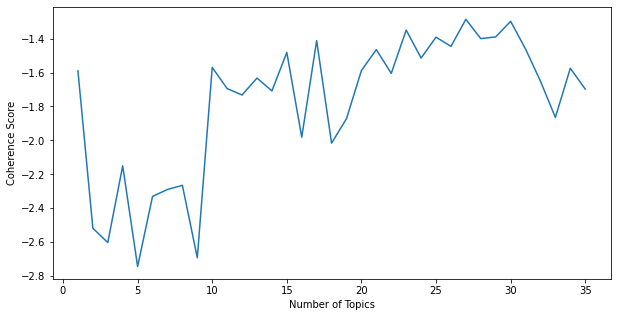

In [33]:
# build a dictionary where for each site, each word has its own id.
text_dictionary = Dictionary(df_text_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
text_corpus = [text_dictionary.doc2bow(text) for text in df_text_clean.tokenized_text]

# compute coherence
text_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(text_corpus, num_topics = nb_topics, id2word = text_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=text_corpus, dictionary=text_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    text_coherence.append(coh)

# visualize coherence
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(1,36),text_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

### Run LDA

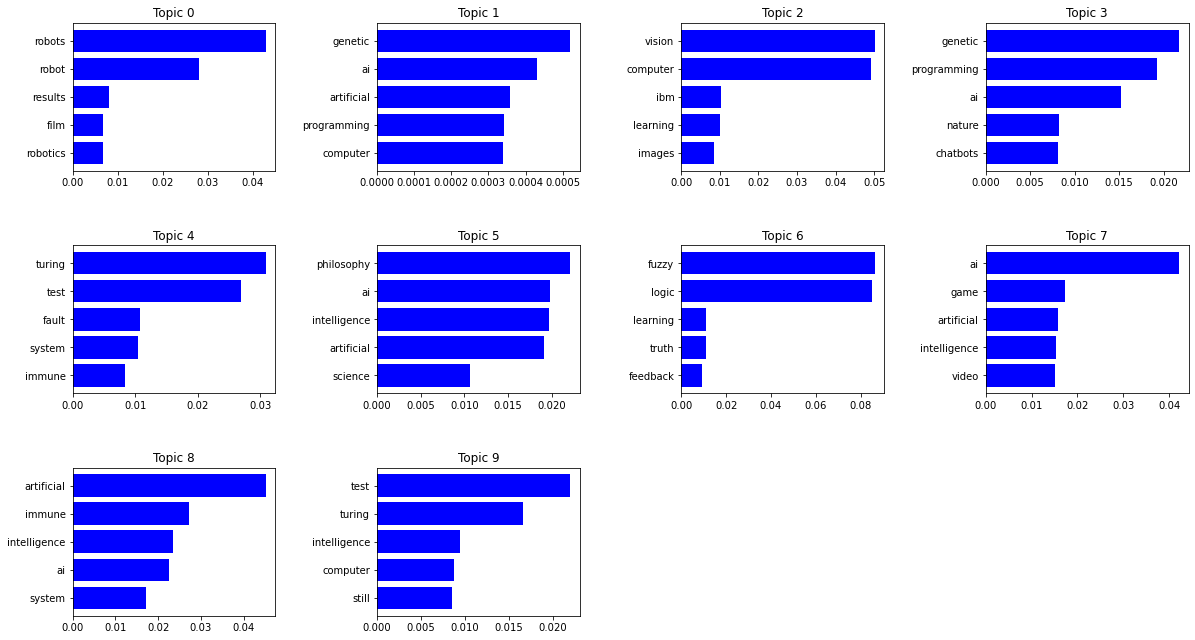

In [41]:
from matplotlib import gridspec

k = 10
text_lda = LdaModel(text_corpus, num_topics = k, id2word = text_dictionary, passes=10)

def plot_top_words(lda=text_lda, nb_topics=k, nb_words=5):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
        
  
plot_top_words()

In [57]:
#notebook adapted from 
#https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835